In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
sales_analysis = pd.read_csv("AusApparalSales4thQrt2020.csv")

In [7]:
# 1a) Inspect missing values
print('\nMissing values (count per column):')
print(sales_analysis.isna().sum())
print('\nBasic info:')
print(sales_analysis.info())
original_cols = sales_analysis.columns.tolist()
clean_cols = [c.strip() if isinstance(c, str) else c for c in original_cols]
if clean_cols != original_cols:
    sales_analysis.columns = clean_cols
    print('\nCleaned column names (trimmed whitespace):')
    print(sales_analysis.columns.tolist())


Missing values (count per column):
Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    7560 non-null   object
 1   Time    7560 non-null   object
 2   State   7560 non-null   object
 3   Group   7560 non-null   object
 4   Unit    7560 non-null   int64 
 5   Sales   7560 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 354.5+ KB
None


In [8]:
# 1b) Recommendations for missing/incorrect data handling
# Example strategy (do not auto-drop without checking):
# - If numeric columns such as 'Sales' or 'Units' have a small number of missing values (<5%), fill with median grouped by similar categorical fields (State, Group/AgeGroup).
# - If many values missing (>30%), consider dropping the column or seeking source data.
# - For categorical missing values, fill with 'Unknown' or the modal value per group.

# We'll implement group-wise median imputation for numeric columns 'Sales' and 'Units' if present.
NUMERIC_COLS = sales_analysis.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns detected:', NUMERIC_COLS)

# Let's detect possible 'Sales' and 'Units' columns (case-insensitive)
cols_lower = [c.lower() for c in sales_analysis.columns]
sales_col = None
units_col = None
for c in sales_analysis.columns:
    if c.lower() in ['sales', 'sale', 'amount', 'revenue']:
        sales_col = c
    if c.lower() in ['units', 'unit', 'quantity', 'qty']:
        units_col = c

print('Detected sales_col =', sales_col, 'units_col =', units_col)

# Imputation helper
def group_median_impute(sales_analysis, col, groupby_cols=['State', 'Group']):
    if col not in sales_analysis.columns:
        return sales_analysis
    if sales_analysis[col].isna().sum() == 0:
        return sales_analysis
    # Try groupby with recommended columns, fall back if those don't exist
    available_groups = [g for g in groupby_cols if g in sales_analysis.columns]
    if available_groups:
        medians = sales_analysis.groupby(available_groups)[col].median()
        # fill using group medians
        def fill_row(r):
            key = tuple(r[g] for g in available_groups)
            try:
                return medians.loc[key]
            except Exception:
                return np.nan
        filled = sales_analysis.apply(lambda r: fill_row(r) if pd.isna(r[col]) else r[col], axis=1)
        # final fallback: overall median
        overall_median = sales_analysis[col].median()
        sales_analysis[col] = filled.fillna(overall_median)
    else:
        # no grouping columns present -> fill with overall median
        sales_analysis[col] = sales_analysis[col].fillna(sales_analysis[col].median())
        return sales_analysis

# Apply imputation to sales & units columns
if sales_col:
    sales_analysis = group_median_impute(sales_analysis, sales_col)
if units_col:
    sales_analysis = group_median_impute(sales_analysis, units_col)


print('\nMissing after imputation (count per column):')
print(sales_analysis.isna().sum())


Numeric columns detected: ['Unit', 'Sales']
Detected sales_col = Sales units_col = Unit

Missing after imputation (count per column):
Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64


In [11]:
# 1c) Normalization: We'll perform Min-Max scaling (preferred for interpretability) on numeric columns used for modeling/visualization.
# Allow the user to switch to StandardScaler if desired.
to_normalize = []
for c in NUMERIC_COLS:
    # exclude ID-like columns if they exist
    if c.lower() in ['id', 'orderid', 'order_id']:
        continue
    to_normalize.append(c)
print('Numeric columns to normalize:', to_normalize)

scaler = MinMaxScaler()
if to_normalize:
    df_norm = sales_analysis.copy()
    df_norm[to_normalize] = scaler.fit_transform(sales_analysis[to_normalize])
    OUTPUT_DIR = 'output'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    # Save normalized version
    norm_path = os.path.join(OUTPUT_DIR, 'AusApparalSales4thQrt2020_normalized.csv')
    df_norm.to_csv(norm_path, index=False)
    print(f'Normalized numeric columns and saved normalized CSV to: {norm_path}')
else:
    df_norm = sales_analysis.copy()
    print('No numeric columns found for normalization.')

Numeric columns to normalize: ['Unit', 'Sales']
Normalized numeric columns and saved normalized CSV to: output\AusApparalSales4thQrt2020_normalized.csv


In [12]:
# 1d) GroupBy discussion & recommendation (printed as text in this cell)
print('\nGroupBy() guidance:')
print("- Use sales_analysis.groupby(['State']) to aggregate revenue and units at the state level (best for identifying top states).")
print("- Use sales_analysis.groupby(['State','Group']) to get two-dimensional aggregation (state x demographic group). Useful for targeted sales programs.")
print("- For time-series grouping, set a datetime index and use sales_analysis.resample('W') / 'M' / 'Q' for weekly/monthly/quarterly reports.")
print('\nRecommendation: Use groupby for slice-and-dice analysis (state & demographic). Use resample on datetime index for time-based chunking.')


GroupBy() guidance:
- Use sales_analysis.groupby(['State']) to aggregate revenue and units at the state level (best for identifying top states).
- Use sales_analysis.groupby(['State','Group']) to get two-dimensional aggregation (state x demographic group). Useful for targeted sales programs.
- For time-series grouping, set a datetime index and use sales_analysis.resample('W') / 'M' / 'Q' for weekly/monthly/quarterly reports.

Recommendation: Use groupby for slice-and-dice analysis (state & demographic). Use resample on datetime index for time-based chunking.



Columns for descriptive analysis: ['Sales', 'Unit']

Descriptive statistics summary:
 
Sales:\ 
 count: 7560
 mean: 45013.5582010582
 median: 35000.0
 mode: [22500]
 std: 32253.506943966317
 min: 5000.0
 max: 162500.0
 
Unit:\ 
 count: 7560
 mean: 18.00542328042328
 median: 14.0
 mode: [9]
 std: 12.901402777586458
 min: 2.0
 max: 65.0


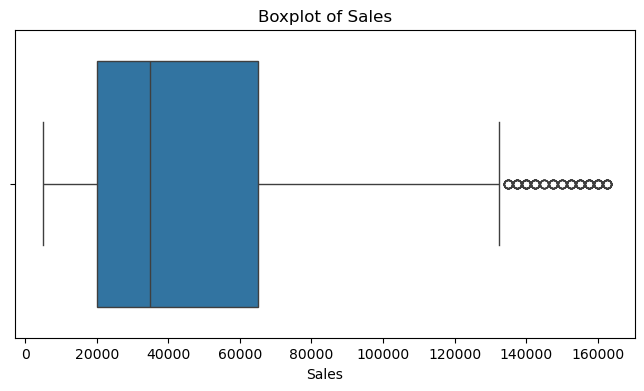

Saved boxplot: output\boxplot_Sales.png


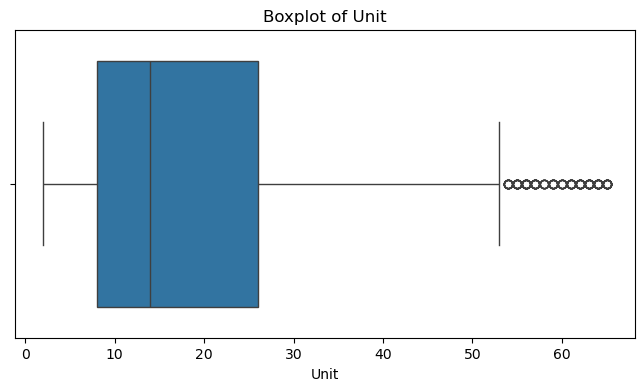

Saved boxplot: output\boxplot_Unit.png


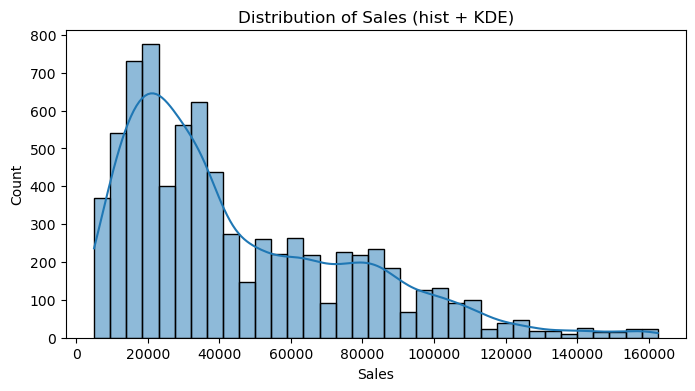

Saved distribution plot: output\dist_Sales.png


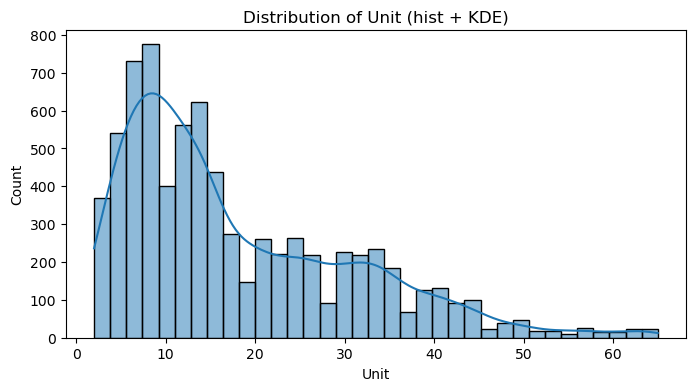

Saved distribution plot: output\dist_Unit.png


In [13]:
# 2) DATA ANALYSIS - DESCRIPTIVE STATISTICS ON SALES & UNITS
analysis_cols = []
if sales_col:
    analysis_cols.append(sales_col)
if units_col:
    analysis_cols.append(units_col)
print('\nColumns for descriptive analysis:', analysis_cols)
stats_summary = {}
for c in analysis_cols:
    col = sales_analysis[c]
    stats_summary[c] = {
        'count': int(col.count()),
        'mean': float(col.mean()),
        'median': float(col.median()),
        'mode': list(pd.Series(stats.mode(col)[0]).tolist()) if col.count()>0 else [],
        'std': float(col.std()),
        'min': float(col.min()),
        'max': float(col.max())
    }
print('\nDescriptive statistics summary:')
for k,v in stats_summary.items():
    print(f" \n{ k }:\ ")
    for kk, vv in v.items():
        print(f" {kk}: {vv}")

# Boxplot for Sales & Units
for c in analysis_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=sales_analysis[c])
    plt.title(f'Boxplot of {c}')
    fname = os.path.join(OUTPUT_DIR, f'boxplot_{c}.png')
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    print(f'Saved boxplot: {fname}')
    plt.close()

# Seaborn distribution plots
for c in analysis_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(sales_analysis[c].dropna(), kde=True)
    plt.title(f'Distribution of {c} (hist + KDE)')
    fname = os.path.join(OUTPUT_DIR, f'dist_{c}.png')
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    print(f'Saved distribution plot: {fname}')
    plt.close()

In [14]:
# 2b & 2c) Identify groups with highest/lowest sales
# Common group column names: 'Group', 'Category', 'Demographic', 'AgeGroup'
GROUP_CANDIDATES = ['Group', 'Category', 'Demographic', 'AgeGroup', 'Age_Group', 'Segment']
group_col = None
for g in GROUP_CANDIDATES:
    if g in sales_analysis.columns:
        group_col = g
        break
print('\nDetected group column =', group_col)
if sales_col:
    # State-level totals
    if 'State' in sales_analysis.columns:
        state_sales = sales_analysis.groupby('State')[sales_col].sum().sort_values(ascending=False)
        print('\nState total sales (top 10):')
        display(state_sales.head(10))
        state_sales.to_csv(os.path.join(OUTPUT_DIR,'state_sales_totals.csv'))
    # Group-level totals
    if group_col:
        group_sales = sales_analysis.groupby(group_col)[sales_col].sum().sort_values(ascending=False)
        print(f'\n{group_col} total sales:')
        display(group_sales)
        group_sales.to_csv(os.path.join(OUTPUT_DIR,'group_sales_totals.csv'))
    # Combined state x group pivot
    if 'State' in sales_analysis.columns and group_col:
        pivot = sales_analysis.pivot_table(values=sales_col, index='State', columns=group_col, aggfunc='sum', fill_value=0)
        pivot.to_csv(os.path.join(OUTPUT_DIR,'state_group_pivot.csv'))
        print('\nSaved state x group sales pivot to outputs/state_group_pivot.csv')

# Identify highest and lowest state
if sales_col and 'State' in sales_analysis.columns:
    highest_state = state_sales.idxmax()
    lowest_state = state_sales.idxmin()
    print(f'\nHighest revenue state: {highest_state} — Sales = {state_sales.max()}')
    print(f'Lowest revenue state: {lowest_state} — Sales = {state_sales.min()}')

# Identify highest/lowest group
if sales_col and group_col:
    highest_group = group_sales.idxmax()
    lowest_group = group_sales.idxmin()
    print(f'\nHighest sales group: {highest_group} — Sales = {group_sales.max()}')
    print(f'Lowest sales group: {lowest_group} — Sales = {group_sales.min()}')


Detected group column = Group

State total sales (top 10):


State
VIC    105565000
NSW     74970000
SA      58857500
QLD     33417500
TAS     22760000
NT      22580000
WA      22152500
Name: Sales, dtype: int64


Group total sales:


Group
Men        85750000
Women      85442500
Kids       85072500
Seniors    84037500
Name: Sales, dtype: int64


Saved state x group sales pivot to outputs/state_group_pivot.csv

Highest revenue state:  VIC — Sales = 105565000
Lowest revenue state:  WA — Sales = 22152500

Highest sales group:  Men — Sales = 85750000
Lowest sales group:  Seniors — Sales = 84037500



Detected datetime column: Date — attempting to parse
Saved daily sales to outputs/daily_sales.csv
Saved weekly sales to outputs/weekly_sales.csv
Saved monthly sales to outputs/monthly_sales.csv
Saved quarterly sales to outputs/quarterly_sales.csv


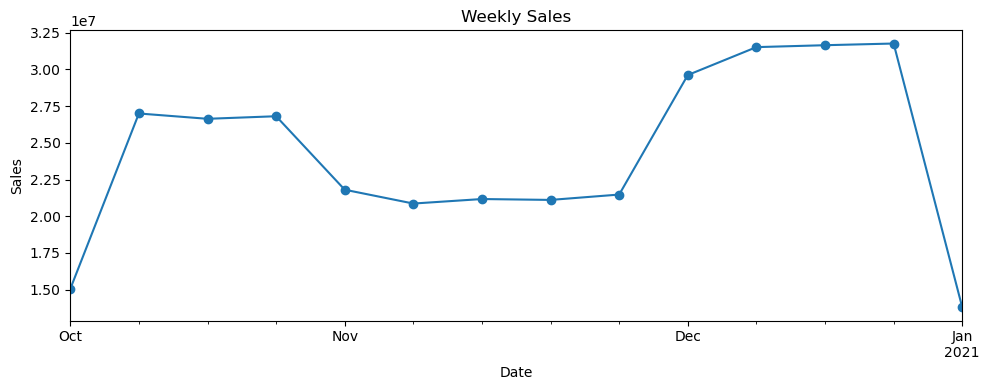

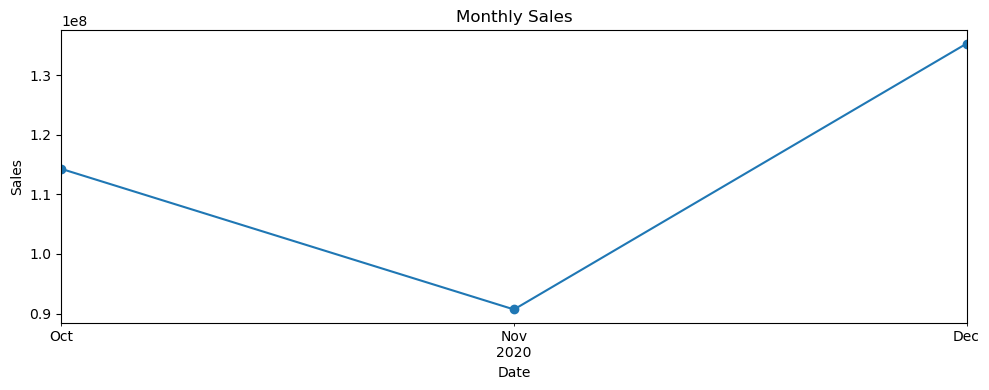

In [20]:
# 2d) Generate weekly, monthly, quarterly reports
dt_col = None
DATE_CANDIDATES = ['Date', 'date', 'OrderDate', 'order_date', 'Datetime', 'timestamp']
for c in DATE_CANDIDATES:
    if c in sales_analysis.columns:
        dt_col = c
        break
if dt_col is None:
    print('\nNo explicit date column detected. If you have a date/time column, rename it to one of:', DATE_CANDIDATES)
else:
    print(f'\nDetected datetime column: {dt_col} — attempting to parse')
    sales_analysis[dt_col] = pd.to_datetime(sales_analysis[dt_col], errors='coerce')
    if sales_analysis[dt_col].isna().sum() > 0:
        print(f'Warning: {sales_analysis[dt_col].isna().sum()} rows could not be parsed as datetime and will be dropped for time-based reporting.')
    df_time = sales_analysis.dropna(subset=[dt_col]).copy()
    df_time = df_time.set_index(dt_col)

# Daily
daily = df_time.resample('D')[sales_col].sum()
daily.to_csv(os.path.join(OUTPUT_DIR,'daily_sales.csv'))
print('Saved daily sales to outputs/daily_sales.csv')

# Weekly (ISO week)
weekly = df_time.resample('W')[sales_col].sum()
weekly.to_csv(os.path.join(OUTPUT_DIR,'weekly_sales.csv'))
print('Saved weekly sales to outputs/weekly_sales.csv')

# Monthly
monthly = df_time.resample('M')[sales_col].sum()
monthly.to_csv(os.path.join(OUTPUT_DIR,'monthly_sales.csv'))
print('Saved monthly sales to outputs/monthly_sales.csv')

# Quarterly
quarterly = df_time.resample('Q')[sales_col].sum()
quarterly.to_csv(os.path.join(OUTPUT_DIR,'quarterly_sales.csv'))
print('Saved quarterly sales to outputs/quarterly_sales.csv')

# Plot time series (monthly + weekly)
plt.figure(figsize=(10,4))
weekly.plot(marker='o')
plt.title('Weekly Sales')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(10,4))
monthly.plot(marker='o')
plt.title('Monthly Sales')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()
plt.close()


Detected demographic-like columns: []


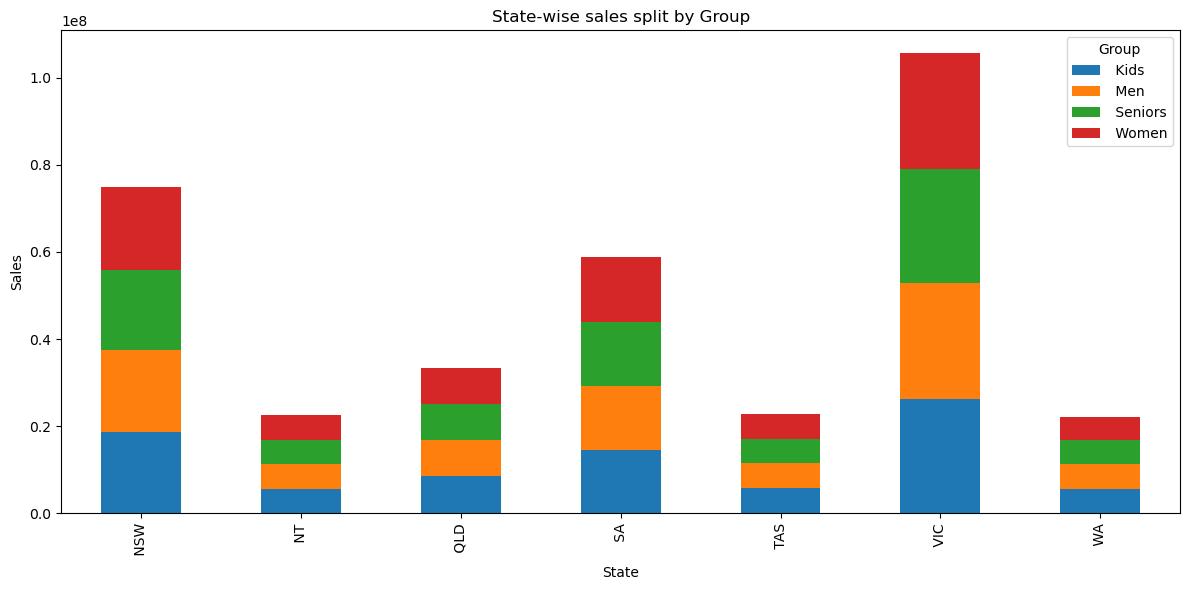

Saved: output\hourly_sales.png


In [22]:
# 3a State-wise sales by demographic groups (kids, women, men, seniors)
DEM_GROUPS = ['Kids', 'Women', 'Men', 'Seniors', 'Elderly', 'Senior']
enum_dem_cols = [c for c in sales_analysis.columns if any(d.lower() in c.lower() for d in DEM_GROUPS)]
print('\nDetected demographic-like columns:', enum_dem_cols)

if enum_dem_cols:
    # plot per state stacked bars
    demo_cols = enum_dem_cols
    if 'State' in sales_analysis.columns:
        demo_pivot = sales_analysis.groupby('State')[demo_cols].sum()
        demo_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
        plt.title('State-wise sales split by detected demographic-like columns')
        plt.ylabel('Sales')
        plt.tight_layout()
        plt.savefig(fname)
        plt.show()
        plt.close()
        print('Saved:', fname)
else:
    # Use Group column values
    if group_col and 'State' in sales_analysis.columns:
        pivot = sales_analysis.pivot_table(values=sales_col, index='State', columns=group_col, aggfunc='sum', fill_value=0)
        pivot.plot(kind='bar', stacked=True, figsize=(12,6))
        plt.title('State-wise sales split by Group')
        plt.ylabel('Sales')
        plt.tight_layout()
        plt.savefig(fname)
        plt.show()
        plt.close()
        print('Saved:', fname)

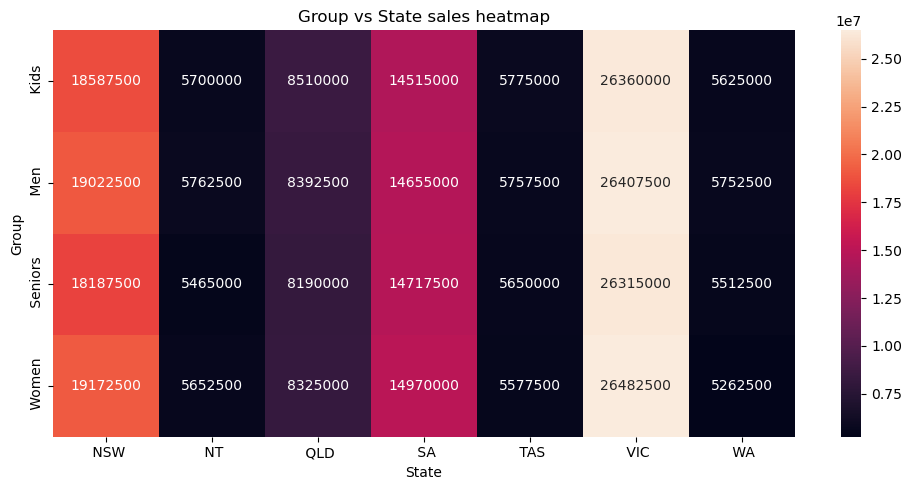

Saved: output\hourly_sales.png


In [29]:
# 3b Group-wise sales across states - heatmap
if group_col and 'State' in sales_analysis.columns:
    pivot = sales_analysis.pivot_table(values=sales_col, index=group_col, columns='State', aggfunc='sum', fill_value=0)
    plt.figure(figsize=(10,5))
    sns.heatmap(pivot, annot=True, fmt='.0f')
    plt.title('Group vs State sales heatmap')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()
    plt.close()
    print('Saved:', fname)

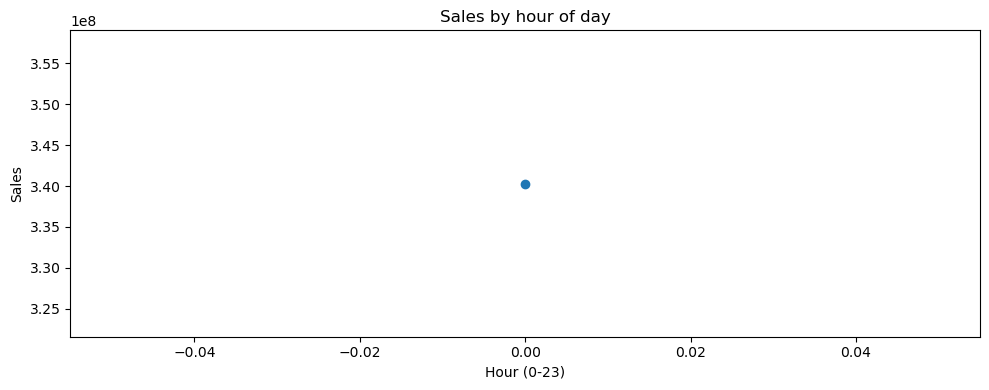

Saved hourly sales plot: output\hourly_sales.png


In [25]:
# 3c Time-of-day analysis: identify peak/off-peak hours
if dt_col:
    if dt_col in sales_analysis.columns:
        df_time = sales_analysis.copy()
        df_time[dt_col] = pd.to_datetime(df_time[dt_col], errors='coerce')
        df_time['hour'] = df_time[dt_col].dt.hour
        hour_sales = df_time.groupby('hour')[sales_col].sum()
        plt.figure(figsize=(10,4))
        hour_sales.plot(marker='o')
        plt.title('Sales by hour of day')
        plt.xlabel('Hour (0-23)')
        plt.ylabel('Sales')
        plt.tight_layout()
        plt.savefig(fname)
        plt.show()
        plt.close()
        print('Saved hourly sales plot:', fname)
    else:
        print('Datetime column not in dataframe — time-of-day analysis skipped.')
else:
    print('No datetime column detected — time-of-day analysis skipped. If you have a time column (e.g., "Time"), please rename it to one of:', TIME_CANDIDATES)

In [27]:
# 4) REPORT GENERATION: Save a brief markdown summary report and CSVs
summary_lines = []
summary_lines.append('# AAL 4th Quarter 2020 - Summary Report')
summary_lines.append('\n')
summary_lines.append('## Key points')
if sales_col and 'State' in sales_analysis.columns:
    summary_lines.append(f"- Highest revenue state: {highest_state} — Sales = {state_sales.max()}")
    summary_lines.append(f"- Lowest revenue state: {lowest_state} — Sales = {state_sales.min()}")
if sales_col and group_col:
    summary_lines.append(f"- Highest sales group: {highest_group} — Sales = {group_sales.max()}")
    summary_lines.append(f"- Lowest sales group: {lowest_group} — Sales = {group_sales.min()}")
summary_lines.append('\n## Recommendations (concise)')
summary_lines.append('- Focus expansion investment in top-performing states while designing targeted programs for low-performing states using group-wise insights.')
summary_lines.append('- For states with low revenue, create group-specific promotions (e.g., if Kids show low sales, run school season campaigns).')
summary_lines.append('- Use time-of-day peaks to schedule promotions/hyper-personalized offers during high-conversion windows.')
summary_lines.append('- Keep normalized features (MinMax) for any downstream ML or similarity scoring; Standardization if model assumes normality.')

# Also export aggregated tables
if 'State' in sales_analysis.columns and sales_col:
    state_sales.to_csv(os.path.join(OUTPUT_DIR,'state_sales_totals.csv'))
if group_col and sales_col:
    group_sales.to_csv(os.path.join(OUTPUT_DIR,'group_sales_totals.csv'))

print(summary_lines)

['# AAL 4th Quarter 2020 - Summary Report', '\n', '## Key points', '- Highest revenue state:  VIC — Sales = 105565000', '- Lowest revenue state:  WA — Sales = 22152500', '- Highest sales group:  Men — Sales = 85750000', '- Lowest sales group:  Seniors — Sales = 84037500', '\n## Recommendations (concise)', '- Focus expansion investment in top-performing states while designing targeted programs for low-performing states using group-wise insights.', '- For states with low revenue, create group-specific promotions (e.g., if Kids show low sales, run school season campaigns).', '- Use time-of-day peaks to schedule promotions/hyper-personalized offers during high-conversion windows.', '- Keep normalized features (MinMax) for any downstream ML or similarity scoring; Standardization if model assumes normality.']
